# 3) Signal Processing on the Digital Reconstruction of the Brain


In this notebook we'll focus on predicting whether a neuron belongs to layer 6 or not knowing only the following information:

- a sample of 10% of the neurons for which we know their layer.
- the connectivity matrix of the microcircuit

and the following technique:

- a revisted version of linear regression using an additional constraint: the solution is smooth on the graph.

In [0]:
##force not printing
%%capture 
%matplotlib inline
!pip install h5py
!pip install pygsp
import numpy as np
import numpy.ma as ma
import h5py 
from scipy import sparse
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib.colors as col
import re
import networkx as nx
import scipy as sp
import scipy.sparse as sps
from scipy.sparse import coo_matrix, hstack, vstack, csr_matrix
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import pygsp as gsp
from pygsp import graphs, filters, plotting, features
import pygsp 

In [0]:
##read .h5 file format containing the information about the microcolumn of the averege individual. Run load_ntds_project before this cell!
file_name='cons_locs_pathways_mc2_Column.h5'
h5=h5py.File(file_name,'r')


## 3.1) Signal Processing with the Unweighted Connectivity Matrix: layers prediction

[Download here the symmetric  connectivity matrix](https://drive.google.com/uc?export=download&id=17VJ5Jwo6j-x-hKJbiuEe2Ltauz906LGJ)

In [0]:
#read .h5 file format containing the symmetric connection matrix
file_name='conn_matrix.h5'
h5_conn=h5py.File(file_name,'r')
conn_tot=h5_conn['binary']

In [0]:
N=31346
m_values=list(h5['populations'].keys())


In [0]:
##to plot signal
def singleplt2dembeddings(x,y,col1,colmap=None,size=0.3,title1='Embedding with normalized Laplacian eigenmaps'):
  plt.figure(figsize=(15,5))

  plt.title(title1)
  plt.scatter(x, y,c=col1,cmap=colmap, alpha=0.6,s=size)
  plt.xlabel('Eigenvector 1')
  plt.ylabel('Eigenvector 2')
  plt.colorbar()

In [0]:
##preparing layers labels
m_type=dict()
for i in range(0, len(m_values)):
        m_type[i] =m_values[i] 
num_neuron=dict()
for i in range(0, len(m_values)):
        num_neuron[i]=len(list(h5['populations'][m_type[i]]['locations']))
label_layer=[]
label_layer_morpho=[]
for i in m_type.keys():
  label_layer.extend(num_neuron[i]*list(map(int, re.findall(r'^\D*(\d+)', m_type[i]))))
label_layer = [v if v!= 23 else 2 for v in label_layer]
label_layer_array = np.asarray(label_layer)

In [0]:
x = np.ones(N) 
x[label_layer_array == 6] = -1

def prepare_observations(x,p):
    #Prepare observations, where p is the percentage of values to keep
    rs = np.random.RandomState(42)
    M = np.array(rs.uniform(size=N) < p)
    return np.multiply(M,x), M

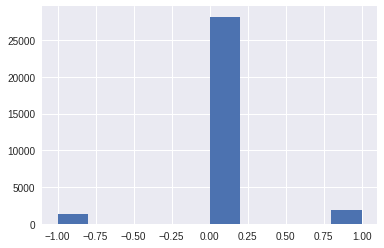

In [8]:
y, M = prepare_observations(x,p=0.1) #we keep "only" 10 percent of the original data
plt.hist(y);

The problem we then want to solve is
$$\mathbf{x}^* = \operatorname*{arg\,min}_{\mathbf{x} \in \mathbb{R}^N} \|\mathbf{y} - \mathbf{Mx}\|_2^2 + \alpha \mathbf{x}^\intercal \mathbf{L} \mathbf{x},$$
where $\alpha$ is an hyper-parameter which controls the trade-off between the data fidelity term and the smoothness prior.

This problem is a convex problem. One particularity is, that there is a global minimum. Thus, if we compute the derivative, we should be able to retrieve this global minimum, because that will be where the derivative is equal to zero. Finally we need to solve :  
$
\left( \mathbf{M}^2 + \alpha \mathbf{L} \right) \mathbf{x}^* = \mathbf{My}
$</font>

In [9]:
#create conn_tot and L sparse matrices
conn_tot=csr_matrix(conn_tot)
L=sps.csgraph.laplacian(conn_tot,normed=True)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


To solve this problem, the [lsqr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html) solver is an efficient way to do it. It is an iterative method to approximate the solution.

In [0]:
#retrieve the first 3 eigenvetors and eigenvalues
evalues_norm, evect_norm =sp.sparse.linalg.eigsh(L,k=3,which="SM")
x_norm = evect_norm[:,1]
y_norm = evect_norm[:,2]

In [0]:
M=[int(M[i]) for i in range(len(M))]

In [0]:
def solve(y,M, L, alpha):
    M1=sp.sparse.diags(M)
    A= M1.dot(M1)+L.multiply(alpha)
    B = M1.dot(y)
    x_star, istop, itn, r1norm,r2norm = sp.sparse.linalg.lsqr(A, B)[:5]
    return  x_star
x_star = solve(y, M, L, alpha=0.01)


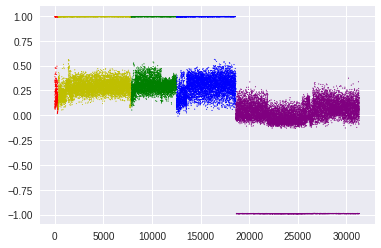

In [13]:
colors = ['r','y','w','g','b','purple']
ycoord=[x for x in range(31346)]
plt.scatter(ycoord,x_star,s=0.5,c=label_layer,cmap=col.ListedColormap(colors))

The result above shows that different layers are separated by a sharp discontinuity in the reconstructed signal. The understanding of "why" is not obvious, bit it is interesting to notice it.  

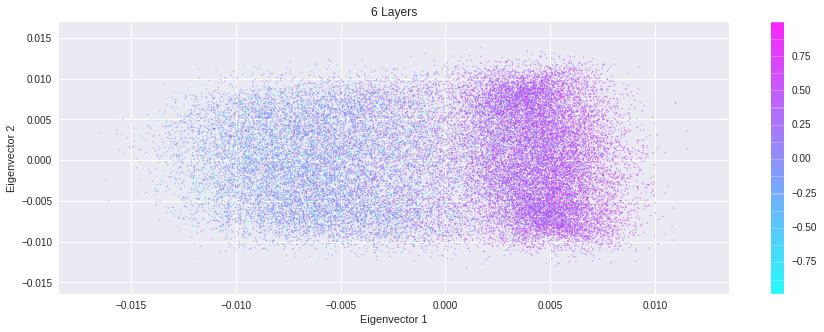

In [14]:
singleplt2dembeddings(x_norm,y_norm, col1=x_star,colmap='cool',size=0.8, title1= '6 Layers', )

In [15]:
##deciding value
value=np.mean(x_star)
x_pred = x_star.copy()
x_pred[x_pred>value]=1
x_pred[x_pred<=value]=-1


# Be sure that the prediction is binary.
np.testing.assert_equal(abs(x_pred), 1)

# Error rate.
err = np.count_nonzero(x - x_pred) 
print('We can predict if a neuron is in the 6th layer, or not, with a percentage of error equal to : {:.2%}, number of errors : {}'.format(err/N, err))

We can predict if a neuron is in the 6th layer, or not, with a percentage of error equal to : 7.55%, number of errors : 2367


**Result : ** By taking only 10% of the original data, the layer 6 could be predict with a small error (7.55%).

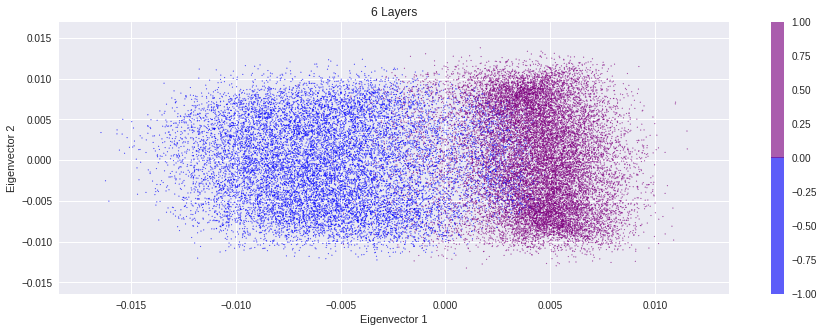

In [16]:
colors = ['b','purple']
singleplt2dembeddings(x_norm,y_norm, col1=x_pred,colmap=col.ListedColormap(colors),size=0.8, title1= '6 Layers', )

## 3.2) Signal Processing with the Weighted Connectivity Matrix: layers prediction

We will keep the same observations as for the unweighted matrix.

[Download here the weighted connectivity matrix (failures mean)](https://drive.google.com/uc?export=download&id=1HLiRD93k9gq0oJbpm5IYRlhqB5j3j98O)

In [0]:
##load already computed weighted matrix
file_name='fail_weight.h5'
h5_dist=h5py.File(file_name,'r')
conn_fail=h5_dist['weight']


In [18]:
conn_fail=csr_matrix(conn_fail)
L_fail=sps.csgraph.laplacian(conn_fail,normed=True)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


In [0]:
evalues_norm_fail, evect_norm_fail =sp.sparse.linalg.eigsh(L_fail,k=3,which="SM")
x_norm_fail = evect_norm_fail[:,1]
y_norm_fail = evect_norm_fail[:,2]

In [0]:
x_star_fail = solve(y, M, L_fail, alpha=0.01)

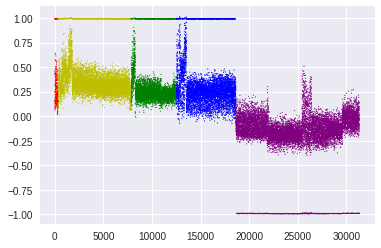

In [21]:
colors = ['r','y','w','g','b','purple']
ycoord=[x for x in range(31346)]
plt.scatter(ycoord,x_star_fail,s=0.5,c=label_layer,cmap=col.ListedColormap(colors))

In [22]:
##deciding value
value_fail=np.mean(x_star_fail)
x_pred_fail = x_star_fail.copy()
x_pred_fail[x_pred_fail>value_fail]=1
x_pred_fail[x_pred_fail<=value_fail]=-1


# Be sure that the prediction is binary.
np.testing.assert_equal(abs(x_pred_fail), 1)

# Error rate.
err_fail = np.count_nonzero(x - x_pred_fail) 
print('We can predict if a neuron in the 6th layer, or not, with a percentage of error equal to : {:.2%}, number of errors : {}'.format(err_fail/N, err_fail))

We can predict if a neuron in the 6th layer, or not, with a percentage of error equal to : 4.72%, number of errors : 1481


**Results:** The results obtained by the prediction with either of the matrices have a very low error rate. When keeping only 10% of the original data using the binary connectivity matrix results in an error rate of 7.55% and using the weighted matrix results in an error rate of 4.72%.  
This supports the assumption, that the failure rate is a reasonable measure to be used when distinguishing between the different layers.

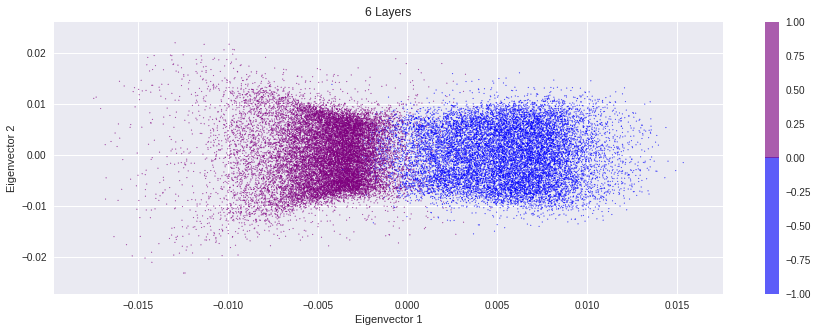

In [23]:
colors = ['b','purple']
singleplt2dembeddings(x_norm_fail,y_norm_fail, col1=x_pred_fail,colmap=col.ListedColormap(colors),size=0.8, title1= '6 Layers', )

# Changing $\alpha$ and "p" parameters

label : result from : <font color = red> **Unweighted** connectivy matrix</font> | <font color = blue> **Weighted** connectivy matrix</font>

<table class="minimalistBlack">
<thead>
<tr>
<th>p</th>
<th>$\alpha$ = 0.01</th>
<th>$\alpha$ = 0.1</th>
<th>$\alpha$ = 1</th>

</tr>
</thead>
<tbody>
<tr>
<tr>
<td>0.05</td>
<td><font color = red>15.6</font> | <font color = blue>8.05</font></td>
<td><font color = red>16.7</font> | <font color = blue>8.60</font></td>
<td><font color = red>25.7</font> | <font color = blue>14.6</font></td>
</tr>
<tr>
<td>0.1</td>
<td><font color = red>7.55</font> | <font color = blue>4.72</font></td>
<td><font color = red>8.04</font> | <font color = blue>4.86</font></td>
<td><font color = red>12.7</font> | <font color = blue>6.41</font></td>

</tr>
<tr>
<td>0.2</td>
<td><font color = red>4.93</font> | <font color = blue>3.68</font></td>
<td><font color = red>7.55</font> | <font color = blue>3.69</font></td>
<td><font color = red>6.95</font> | <font color = blue>4.24</font></td>

</tr>
<tr>
<td>0.5</td>
<td><font color = red>2.59</font> | <font color = blue>2.31</font></td>
<td><font color = red>2.62</font> | <font color = blue>2.29</font></td>
<td><font color = red>2.89</font> | <font color = blue>2.24</font></td>
</tr>
</tbody>
</table>

As expected, the same behaviour can be observed as in the last assignment (NTDS assignment 4: graph signal processing). As $\alpha$ is the hyper-parameter which controls the trade-off between the data fidelity term and the smoothness prior, if it is increased, the percentage of errors increases. The opposite is also true. Concerning the probabiliy, it can be noticed (and that makes sense) that if more values are kept (bigger "p") from the original observations to compute the prediction, the amount of errors between the original and the prediction values decrease. 

## 3.2)Signal Processing with the Weighted Connectivity Matrix: E/I prediction

In this section we'll try to predict whether a neuron is excitatory or inhibitory (E\I) using as an underlying graph the structural connectivity matrix of the microcircuit weighted wit the failure mean. The technique used for the prediction is the same as in section 3.1) and 3.2).

The labels of E\I have been manually created by looking at the classification given in ['Reconstruction and Simulation of Neocortical Microcircuitry'](http://www.cell.com/cell/pdf/S0092-8674%2815%2901191-5.pdf) (Markram et al., 2015; Cell). 

In [0]:
lab_EI=[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1]

In [0]:
label_EI=[]
for i in m_type.keys():
  label_EI.extend(num_neuron[i]*[lab_EI[i]])

In [26]:
E=[label_EI[i] for i in range(N) if label_EI[i]==1]
E=sum(E)
I=N-E
print('In the microcircuit there are {} excitatory neurons and {} inhibitory neurons'.format(E,I))

In the microcircuit there are 21755 excitatory neurons and 9591 inhibitory neurons


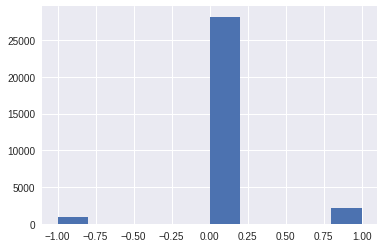

In [27]:
##prepare observation 
yEI, MEI = prepare_observations(label_EI,p=0.1) #we keep "only" 10 percent of E\I labels
plt.hist(yEI);

In [0]:
MEI=[int(MEI[i]) for i in range(len(MEI))]

In [0]:
## predict the remaining 90% of the E/I labels
x_star_EI = solve(yEI, MEI, L_fail, alpha=0.01)

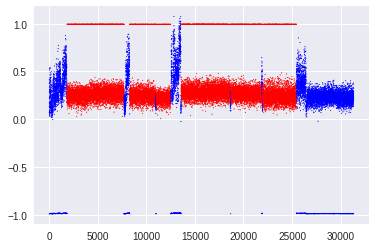

In [30]:
colors = ['b','r']
ycoord=[x for x in range(31346)]
plt.scatter(ycoord,x_star_EI,s=0.5,c=label_EI,cmap=col.ListedColormap(colors))

In [31]:
##deciding value
value_EI=np.mean(x_star_EI) 
x_pred_EI = x_star_EI.copy()
x_pred_EI[x_pred_EI>value_EI]=1
x_pred_EI[x_pred_EI<=value_EI]=-1
# Be sure that the prediction is binary.
np.testing.assert_equal(abs(x_pred_EI), 1)
# Error rate.
err_EI = np.count_nonzero(label_EI - x_pred_EI) 
print('We can predict if a neuron is inhibitory or excitatory with a percentage of error equal to : {:.2%}, number of errors : {}'.format(err_EI/N, err_EI))

We can predict if a neuron is inhibitory or excitatory with a percentage of error equal to : 53.21%, number of errors : 16678


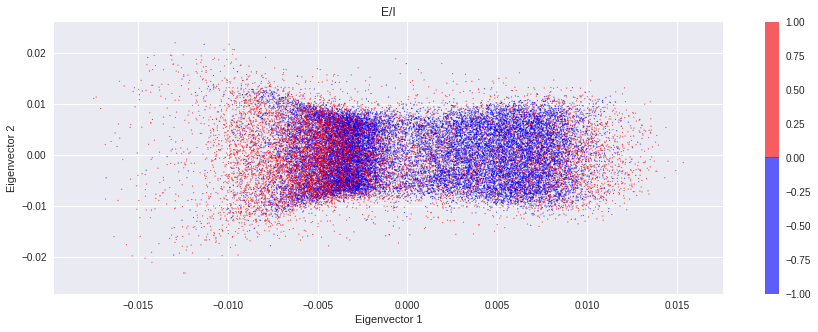

In [32]:
colors = ['b','r']
singleplt2dembeddings(x_norm_fail,y_norm_fail, col1=x_pred_EI,colmap=col.ListedColormap(colors),size=0.8, title1= 'E/I', )

**Result:** The presented method is not an accurate prediction to distinguish between inhibitory and excitatory neurons. Probably the constructed underlying graph doesn't carry much information about this biological property of the neurons. Further investigation could be done by choosing more biologically related weights for the structural graph of the microcircuit.